# LSTM-ED MODEL


In [1]:
import numpy as np 
import pandas as pd 

import pydot

#import keras 
import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model

import keras.backend as Kback

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

from math import exp

model_path = "model_LSTM_Autoencoder.h5"

model_HI_test_path = "model_MLP_HI.h5"

from Perform_function import perform_func 

Using TensorFlow backend.


In [2]:
## Data Ingestion ## from local

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")

# Deleting unuseful columns
train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)
test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


In [ ]:
## Data Ingestion ## from ITH-Tower


train_df = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("/home/eoto/pm_nasa_cmapss/Datasets/CMAPSSData/RUL_FD001.txt")

# Deleting unuseful columns
train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)
test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


In [3]:
#Hyperparameters

sequence_length = 5
health_length = 40

healthy_train = train_df[train_df['Cycle'] <= health_length]
healthy_test = test_df[test_df['Cycle'] <= health_length]


In [4]:
## Principal Component Analysis ##

#Columns to be scaled 

col_permanent = ['Unit', 'Cycle']
col_var = train_df.columns.difference(col_permanent)

# The PCA is introduced in order to reduce the dimensionality 

    # Training dataset

scaler = StandardScaler()
pca = PCA(.95)
train_df_scaled = train_df[col_permanent].join(pd.DataFrame(pca.fit_transform(scaler.fit_transform(train_df[col_var])),
    index=train_df.index))

#scaler = StandardScaler()
test_df_scaled = test_df[col_permanent].join(pd.DataFrame(pca.transform(scaler.transform(test_df[col_var])),
    index=test_df.index))


test_df_scaled.head()


,Unit,Cycle,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,-2.475403,-0.777619,1.482786,0.080010,-0.077868,-0.337896,-0.826615,0.921520,-0.393515,-0.616565,-0.461015,-0.490199
1,1,2,-3.566323,-0.040873,-1.520490,-0.408165,-0.459367,0.561212,1.260243,-0.117897,0.206018,-0.495765,0.167563,0.537475
2,1,3,-2.336877,-0.379826,0.385361,-0.196137,-0.169551,-0.050891,0.401225,0.680498,-0.077260,1.011673,-0.230607,-0.047288
3,1,4,-2.850192,-0.810491,1.328483,1.310859,-0.576017,-0.068813,-0.668261,0.035846,0.225531,-0.174019,0.672236,0.155964
4,1,5,-3.494312,-0.752334,0.477794,0.370824,-0.401362,0.567157,-1.189312,0.103837,-0.134968,0.041174,0.102103,-0.150675


In [ ]:
train_df_scaled.head(10)

In [5]:
#####
#Data formatting#
####

# Data will be input into the RNN in windows with a certain size
sequence_length = 5
health_length = 40

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_health, seq_cols, train = True):
    """ The function creates the sequences based on the number of instances considered into the Recurrent Neuron
    and the number of instances that are considered healthy instances.
    Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    if(train == True): 
        id_df = id_df[id_df['Cycle'] <= seq_health]
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        yield data_matrix[start:stop, :]

sequence_cols = list(train_df_scaled.columns[2:].values)
print(sequence_cols)

#val=list(gen_sequence(train_df[train_df['Unit']==1], sequence_length, sequence_cols))

seq_gen = (list(gen_sequence(train_df_scaled[train_df_scaled['Unit']==id], sequence_length, seq_health = health_length, seq_cols = sequence_cols)) 
           for id in train_df_scaled['Unit'].unique())


# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)
#print(seq_array)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(3600, 5, 12)


In [6]:
model = keras.models.load_model(model_path)

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 400)               660800    
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 5, 400)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 5, 400)            1281600   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 5, 12)             4812      
Total params: 1,947,212
Trainable params: 1,947,212
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Autoencoder ###

# Model definition

model = Sequential()

model.add(LSTM(400, activation='relu', input_shape = (seq_array.shape[1],seq_array.shape[2])))

model.add(RepeatVector(seq_array.shape[1]))

model.add(LSTM(400, activation = 'relu', return_sequences=True))

model.add(TimeDistributed(Dense(seq_array.shape[2])))

model.compile(optimizer='adam', loss = 'mse')

# Model fitting

model.summary()

model.fit(seq_array, seq_array, epochs = 500, verbose = 2, 
    callbacks = [keras.callbacks.ModelCheckpoint(model_path, monitor = 'loss', save_best_only = True, mode = 'min', verbose = 1)])



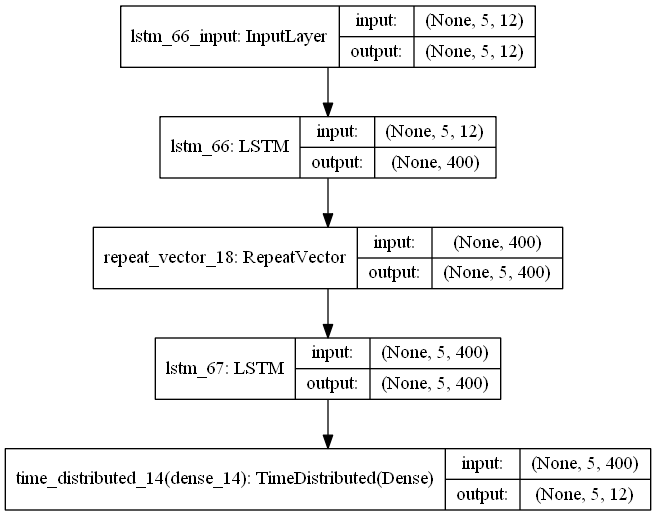

In [7]:
plot_model(model, show_shapes = True)

In [8]:
# Trained Autoencoder model accuracy


yhat = model.predict(seq_array, verbose=0)
error = seq_array - yhat

print("The autoencoder trained accuracy is: {}".format(np.mean(np.abs(error))))

print("Error shape: ", error.shape)

The autoencoder trained accuracy is: 0.027198195457458496
Error shape:  (3600, 5, 12)


In [9]:
## Creo la secuencia para el training set completo 

seq_gen_train = (list(gen_sequence(train_df_scaled[train_df_scaled['Unit']==id], sequence_length, seq_health = health_length, seq_cols = sequence_cols, train = False)) 
           for id in train_df_scaled['Unit'].unique())


# generate sequences and convert to numpy array
seq_array_train = np.concatenate(list(seq_gen_train)).astype(np.float32)

prediction_train_df = model.predict(seq_array_train)

matrix_error = np.abs(prediction_train_df - seq_array_train)

mean_error_train = np.mean(matrix_error, axis = 2)

print("Sequence shape: ", mean_error_train.shape)



Sequence shape:  (20231, 5)


In [ ]:
pd.DataFrame(mean_error_train[:183,:])

In [ ]:
train_df[train_df['Unit']==1].tail(20)

In [10]:
train_df['Sequence'] = 0

n_cycles = 0

for i in pd.unique(train_df['Unit']):

    train_df.loc[train_df['Unit'] == i, 'Sequence'] = train_df.loc[train_df['Unit'] == i, 'Cycle'] + n_cycles

    n_cycles += train_df.loc[train_df['Unit'] == i, 'Cycle'].max() - sequence_length + 1

    train_df.loc[(train_df['Unit'] == i) & (train_df['Cycle'] > train_df.loc[train_df['Unit'] == i, 'Cycle'].max() - sequence_length + 1 ), 'Sequence'] = 0 





In [11]:
train_df['error'] = 0

error_index = train_df.columns.get_loc("error")

for i in pd.unique(train_df['Unit']):

    seq_min = train_df.loc[(train_df['Unit']==i)&(train_df['Sequence']!=0),'Sequence'].min()
    seq_max = train_df.loc[train_df['Unit']==i,'Sequence'].max()

    for j in range(seq_min,seq_max+1):

        index = train_df.loc[(train_df['Unit']==i)&(train_df['Sequence']==j),:].index.values
        #print("Unit", i, "sequence", j)

        for k in range(sequence_length):

                       
            train_df.iloc[index + k, error_index] += mean_error_train[j-1,k]

for i in train_df['Unit'].unique():

    train_df.loc[train_df['Unit'] == i, 'UL'] = train_df.loc[train_df['Unit']==i, 'Cycle'].max() 

num_pred = np.zeros(len(train_df))
for index, row in train_df.iterrows():
    num_pred[index] = min(row['Cycle'], sequence_length, row['UL']-row['Cycle']+1)

train_df['Num_Pred'] = num_pred
train_df['error'] = train_df['error'] / num_pred


In [ ]:
train_df.loc[train_df['Cycle'] < health_length, 'error'] = 0

In [12]:
train_df['Health_Index'] = 0

#train_df.info()

for i in train_df['Unit'].unique():
    
    train_df.loc[train_df['Unit']==i, 'Health_Index'] = (train_df.loc[train_df['Unit']==i, 'error'].max() - train_df.loc[train_df['Unit']==i, 'error']) / (train_df.loc[train_df['Unit']==i, 'error'].max() - train_df.loc[train_df['Unit']==i, 'error'].min())

In [ ]:
train_df[train_df['Unit']==1].head(20)

In [ ]:
pd.DataFrame(mean_error_train).iloc[170:183,:]

In [13]:
def smooth(x,window_len=11,window='hanning'):

    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [14]:
vector_new = train_df[train_df['Unit']==1]['Health_Index']

num = round(len(vector_new)*0.05)

mean_HI_5 = np.mean(vector_new[:num])

vector_new = vector_new/mean_HI_5

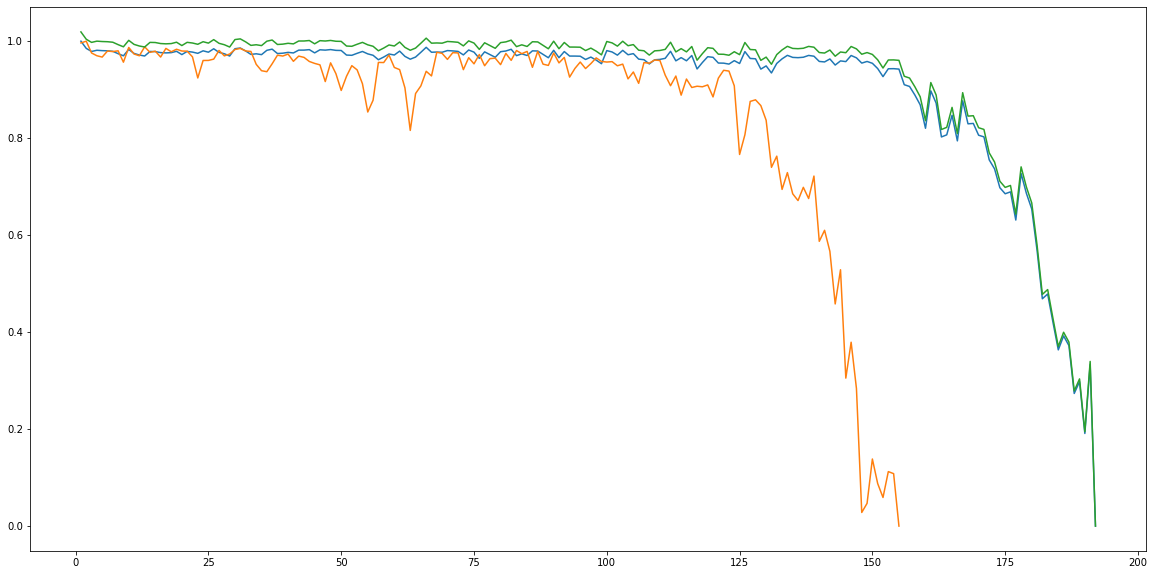

In [15]:
plt.figure(figsize = (20,10))
unit = 1


plt.plot(train_df.loc[train_df['Unit']==unit, 'Cycle'], train_df.loc[train_df['Unit']==unit, 'Health_Index'])

plt.plot(train_df.loc[train_df['Unit']==93, 'Cycle'], train_df.loc[train_df['Unit']==93, 'Health_Index'])

plt.plot(train_df.loc[train_df['Unit']==1, 'Cycle'], vector_new)


In [16]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

In [ ]:
train_df.head()

In [17]:
# Train HI predictor
# Health Index can't be calculated by the same way as in the train set, as there is no minimum HI to calculate the failure.
# Therefore, a MLP is trained in order to predict the HI of every instance

# Model parameters

n_inputs = len(sequence_cols)

# We are going to train the model on the Health Index from 90 turbines, and will be testing on the other ten 

train_HI = train_df_scaled[train_df_scaled['Unit']<=90][sequence_cols]
label_train_HI = train_df[train_df['Unit']<= 90]['Health_Index']

test_HI = train_df_scaled[train_df_scaled['Unit'] >90][sequence_cols]
label_test_HI = train_df[train_df['Unit'] > 90]['Health_Index']




model_HI = Sequential()

model_HI.add(Dense(n_inputs, input_dim = n_inputs, kernel_initializer = 'glorot_normal', activation = 'relu'))
model_HI.add(Dense(5, kernel_initializer = 'glorot_normal', activation = 'relu'))
model_HI.add(Dense(1, kernel_initializer = 'glorot_normal'))

model_HI.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae', r2_keras])

print(model_HI.summary())

# Let's train the model

result = model_HI.fit(train_HI, label_train_HI, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_HI_test_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )

print(result.history.keys())


    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
None
Train on 17461 samples, validate on 919 samples
Epoch 1/100
17461/17461 [==============================] - 1s 59us/step - loss: 0.3246 - mae: 0.4419 - r2_keras: -7.1066 - val_loss: 0.1021 - val_mae: 0.2634 - val_r2_keras: -57.1701
Epoch 2/100
17461/17461 [==============================] - 0s 28us/step - loss: 0.0734 - mae: 0.2140 - r2_keras: -0.7521 - val_loss: 0.0559 - val_mae:

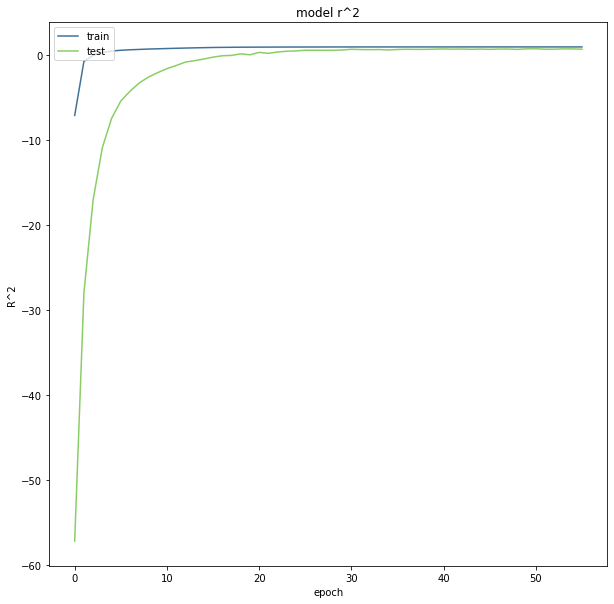

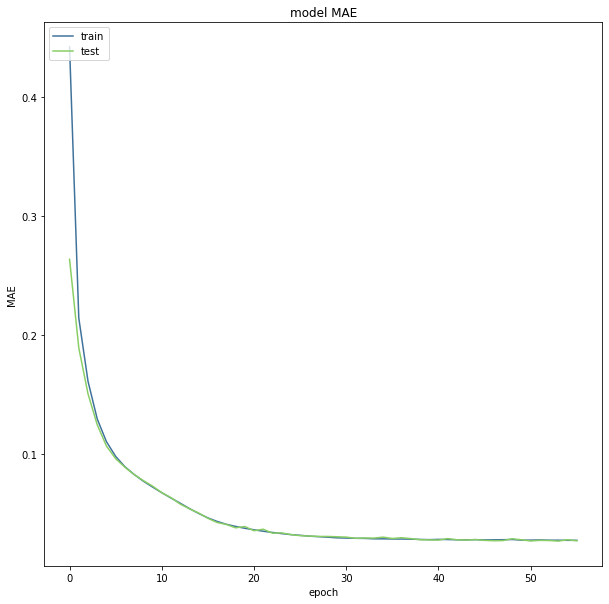

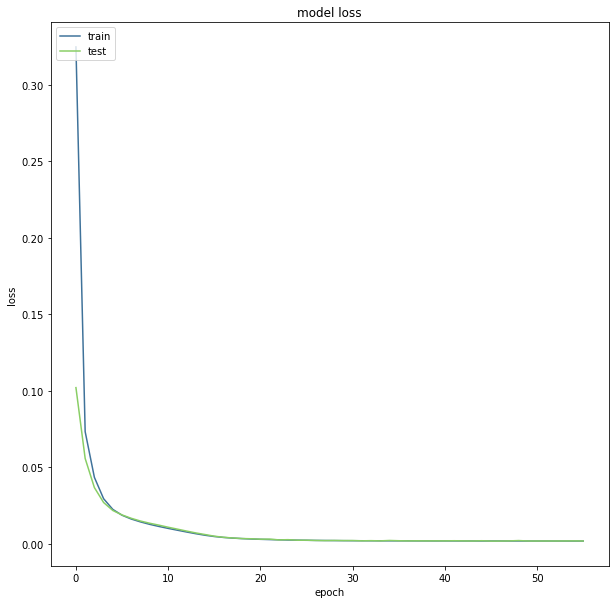

In [18]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [19]:
# training metrics
scores = model_HI.evaluate(train_HI, label_train_HI, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model_HI.predict(test_HI,verbose=1, batch_size=200)
y_true = label_test_HI

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)

18380/18380 [==============================] - 0s 11us/step

MAE: 0.026665249839425087

R^2: 0.9090031385421753
2251/2251 [==============================] - 0s 16us/step



MAE: 0.02999161370098591

R^2: -2.477675199508667


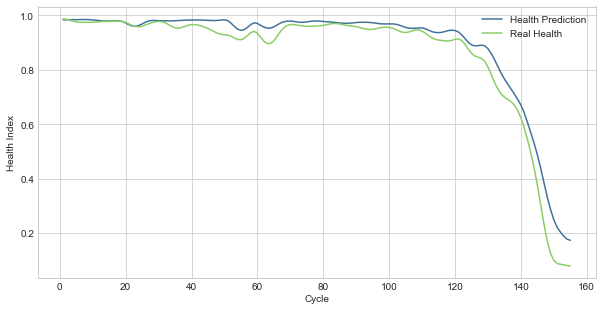

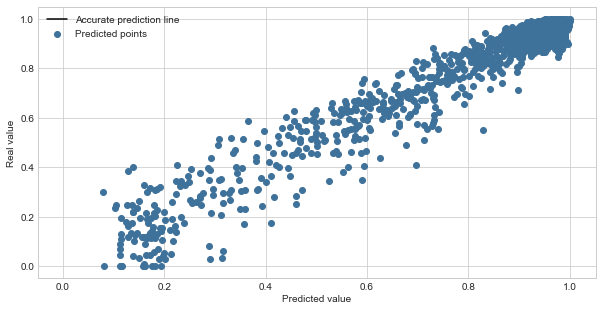

In [20]:
if os.path.isfile(model_HI_test_path):
    
    estimator = load_model(model_HI_test_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(test_HI, label_test_HI, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(test_HI)
    train_df['Health_Index_Predicted'] = 0
    train_df.loc[train_df['Unit']>90, 'Health_Index_Predicted'] = y_pred_test
    y_true_test = label_test_HI

    #test_set = pd.DataFrame(y_pred_test)
    #test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(train_df[train_df['Unit']==93]['Cycle'], smooth(train_df[train_df['Unit']==93]['Health_Index_Predicted'],window_len = 11)[5:-5], color="#3f729a")
    plt.plot( train_df[train_df['Unit']==93]['Cycle'],smooth(train_df[train_df['Unit']==93]['Health_Index'], window_len = 11 )[5:-5], color="#89ce65")
    plt.ylabel('Health Index')
    plt.xlabel('Cycle')
    plt.legend(['Health Prediction', 'Real Health'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

In [ ]:
test_df[test_df['Cycle']==test_df['Cycle'].max()]

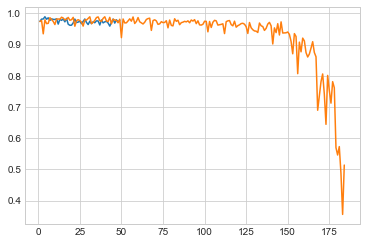

In [21]:

# Create HI curves for test dataset

test_df['Health_Index'] = model_HI.predict(test_df_scaled[sequence_cols])

plt.plot(test_df.loc[test_df['Unit']==2, 'Cycle'], test_df.loc[test_df['Unit']==2, 'Health_Index'])

plt.plot(test_df.loc[test_df['Unit']==20, 'Cycle'], test_df.loc[test_df['Unit']==20, 'Health_Index'])





In [ ]:
test_df.groupby('Unit').min().sort_values('Health_Index')

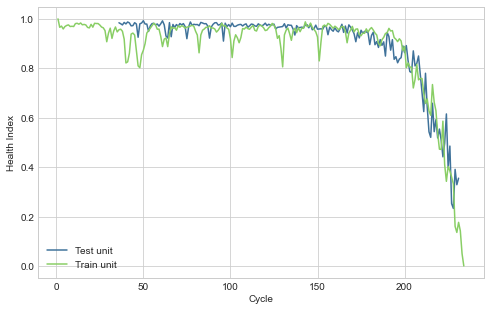

In [22]:
# Create HI curves for test dataset

plt.figure(figsize = (8,5))

plt.plot(test_df.loc[test_df['Unit']==31, 'Cycle']+ 35, test_df.loc[test_df['Unit']==31, 'Health_Index'], color="#3f729a", label = 'Test unit')

plt.plot(train_df.loc[train_df['Unit']==31, 'Cycle'], train_df.loc[train_df['Unit']==31, 'Health_Index'], color="#89ce65", label = 'Train unit')

plt.ylabel("Health Index")
plt.xlabel("Cycle")
plt.legend()

In [ ]:
train_df['Health_Index_Smooth'] = smooth(train_df['Health_Index'], window_len = 11)[5:-5]
test_df['Health_Index_Smooth'] = smooth(test_df['Health_Index'], window_len = 11)[5:-5]

In [ ]:
test_df[test_df['Health_Index']<0.5]

In [23]:
def similarity(test_unit, train_unit, time_lag, lambda_val):

    test_unit = test_unit.to_numpy()
    train_unit = train_unit.to_numpy()

    len_test = len(test_unit)
    len_train = len(train_unit[time_lag:(len_test+time_lag)])

    #print(len_test, len_train)
    #print(time_lag)
    
    distance = (1/len_test) * ((test_unit - train_unit[time_lag:(len_test+time_lag)])**2).sum()

    #print("Distance: ", distance)
    
    return exp(-distance/lambda_val)


max_timelag = 40


similarity_matrix = np.zeros((len(test_df['Unit'].unique()), len(train_df['Unit'].unique()),max_timelag+1))

max_sim = 0
best_time_lag = 0

for test_index in test_df['Unit'].unique():

    for train_index in train_df['Unit'].unique():

        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):

            test_unit = test_df[test_df['Unit']==test_index]['Health_Index']
            train_unit = train_df[train_df['Unit']==train_index]['Health_Index']

            if(len(test_unit) + time_lag <= len(train_unit)):
                
                similarity_matrix[test_index-1, train_index-1, time_lag] = similarity(test_unit,train_unit,time_lag, lambda_val = 0.0005)
            else:

                similarity_matrix[test_index-1, train_index-1, time_lag] = -1

        
#print(max_sim,best_time_lag)

#plt.plot(test_df.loc[test_df['Unit']==20, 'Cycle'] + best_time_lag, test_df.loc[test_df['Unit']==20, 'Health_Index'])

#plt.plot(train_df.loc[train_df['Unit']==96, 'Cycle'], train_df.loc[train_df['Unit']==96, 'Health_Index'])


:91
Train:  45
Test:  91
Train:  46
Test:  91
Train:  47
Test:  91
Train:  48
Test:  91
Train:  49
Test:  91
Train:  50
Test:  91
Train:  51
Test:  91
Train:  52
Test:  91
Train:  53
Test:  91
Train: 54
Test:  91
Train:  55
Test:  91
Train:  56
Test:91
Train:  57
Test:  91
Train:  58
Test:  91
Train:  59
Test:  91
Train:  60
Test:  91
Train:  61
Test:  91
Train:  62
Test:  91
Train:  63
Test:  91
Train:  64
Test:  91
Train:  65
Test:  91
Train:  66
Test:  91
Train:  67
Test:  91
Train:  68
Test:  91
Train:  69
Test:  91
Train:  70
Test:  91
Train:  71
Test:  91
Train:  72
Test:  91
Train:  73
Test:  91
Train:  74
Test:  91
Train:  75
Test:  91
Train:  76
Test:  91
Train:  77
Test:  91
Train:  78
Test:  91
Train:  79
Test:  91
Train:  80
Test:  91
Train:  81
Test:  91
Train:  82
Test:  91
Train:  83
Test:  91
Train:  84
Test:  91
Train:  85
Test:  91
Train:  86
Test:  91
Train:  87
Test:  91
Train:  88
Test:  91
Train:  89
Test:  91
Train:  90
Test:  91
Train:  91
Test: 91
Train:  92
Te

In [24]:
#RUL Prediction

max_RUL_prediction = train_df['UL'].max()

RUL_prediction_matrix = np.zeros(similarity_matrix.shape)

for test_index in test_df['Unit'].unique():

    for train_index in train_df['Unit'].unique():

        test_unit = test_df[test_df['Unit']==test_index]['Health_Index']
        train_unit = train_df[train_df['Unit']==train_index]['Health_Index']

        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):

            if len(test_unit) - time_lag < max_RUL_prediction:

                RUL_prediction_matrix[test_index-1, train_index-1, time_lag] = len(train_unit) - len(test_unit) - time_lag
            
            else:

                RUL_prediction_matrix[test_index-1, train_index-1, time_lag] = max_RUL_prediction






91
Train:  48
Test:  91
Train:  49
Test:  91
Train:  50
Test:  91
Train:  51
Test:  91
Train:  52
Test:  91
Train:  53
Test:  91
Train:  54
Test:  91
Train:  55
Test:  91
Train:  56
Test:  91
Train:  57
Test:  91
Train:  58
Test:  91
Train:  59
Test:  91
Train:  60
Test:  91
Train:  61
Test:  91
Train:  62
Test:  91
Train:  63
Test:  91
Train:  64
Test:  91
Train:  65
Test:  91
Train:  66
Test:  91
Train:  67
Test:  91
Train:  68
Test:  91
Train:  69
Test:  91
Train:  70
Test:  91
Train:  71
Test:  91
Train:  72
Test:  91
Train:  73
Test:  91
Train:  74
Test:  91
Train:  75
Test:  91
Train:  76
Test:  91
Train:  77
Test:  91
Train:  78
Test:  91
Train:  79
Test:  91
Train:  80
Test:  91
Train:  81
Test:  91
Train:  82
Test:  91
Train:  83
Test:  91
Train:  84
Test:  91
Train:  85
Test:  91
Train:  86
Test:  91
Train:  87
Test:  91
Train:  88
Test:  91
Train:  89
Test:  91
Train:  90
Test: 91
Train:  91
Test:  91
Train:  92
Test:  91
Train:  93
Test:  91
Train:  94
Test:  91
Train:  95


In [27]:
RUL_prediction_matrix_save = RUL_prediction_matrix

In [28]:
RUL_prediction_matrix[RUL_prediction_matrix>160]=160

In [29]:
RUL_final_prediction = np.zeros(len(train_df['Unit'].unique()))

alpha = 0.87

for test_index in test_df['Unit'].unique():

    #if test_index == 2:
     #   break
    
    weighted_sum = 0
    similarity_sum = 0

    for train_index in train_df['Unit'].unique():
        
        print("Test: ", test_index)
        print("Train: ", train_index)

        for time_lag in range(max_timelag+1):
            
            if similarity_matrix[test_index -1, train_index -1, time_lag] > similarity_matrix[test_index-1, :, :].max() * alpha:

                print("He entrado: ", similarity_matrix[test_index -1, train_index -1, time_lag])
                print("El limite es: ", similarity_matrix[test_index-1,:, :].max() * alpha)

                weighted_sum += similarity_matrix[test_index -1, train_index -1, time_lag] * RUL_prediction_matrix[test_index -1, train_index -1, time_lag]
                similarity_sum += similarity_matrix[test_index -1, train_index -1, time_lag]

    RUL_final_prediction[test_index-1] = round(weighted_sum/similarity_sum)

    print("Weighted sum: ", weighted_sum)
    print("RUL prediction: ", RUL_final_prediction[test_index-1])

 


 89
Test:  97
Train:  90
Test:  97
Train:  91
Test:  97
Train:  92
He entrado:  0.6769902623926909
El limite es:  0.6558918060389985
He entrado:  0.6807299538358663
El limite es:  0.6558918060389985
He entrado:  0.6631001202635286
El limite es:  0.6558918060389985
He entrado:  0.6610334200781721
El limite es:  0.6558918060389985
He entrado:  0.6745867607091823
El limite es:  0.6558918060389985
He entrado:  0.6934295016282724
El limite es:  0.6558918060389985
He entrado:  0.6674663204251197
El limite es:  0.6558918060389985
He entrado:  0.6580495112503981
El limite es:  0.6558918060389985
He entrado:  0.6698423226187289
El limite es:  0.6558918060389985
He entrado:  0.66919988554416
El limite es:  0.6558918060389985
He entrado:  0.6714262785400117
El limite es:  0.6558918060389985
He entrado:  0.6881114098366096
El limite es:  0.6558918060389985
Test:  97
Train:  93
Test:  97
Train:  94
Test:  97
Train:  95
Test:  97
Train:  96
Test:  97
Train:  97
Test:  97
Train:  98
Test:  97
Train: 

The model score is: 1095.5602748349538
The model accuracy is: 46.0
The model MAE is: 16.62
The model MSE is : 455.06
The model Mean Absolute Percentage Error (MAPE) is: 27.661663220537083
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 8.233013460487916


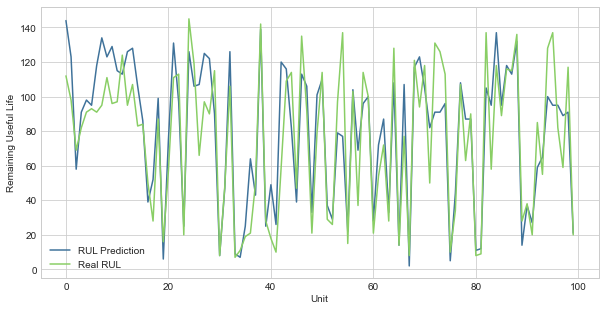

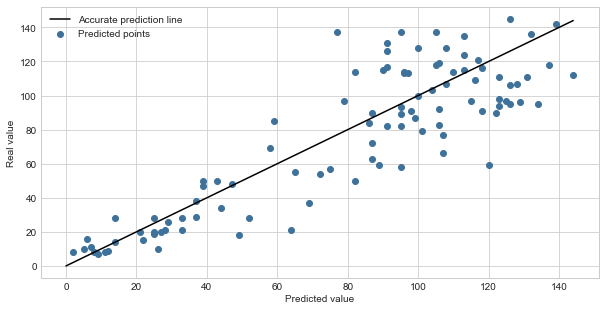

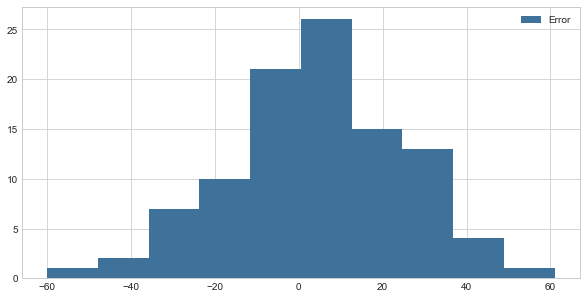

In [30]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(RUL_final_prediction, RUL_test.to_numpy()[:,0], test_df.groupby('Unit').max()['Cycle'].to_numpy())

In [ ]:
test_df[test_df['Unit']==22]

In [ ]:
plt.plot(test_df.loc[test_df['Unit']==12, 'Cycle'] + 19, test_df.loc[test_df['Unit']==12, 'Health_Index'])

plt.plot(train_df.loc[train_df['Unit']==2, 'Cycle'], train_df.loc[train_df['Unit']==2, 'Health_Index'])


In [34]:
test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)


error_df = pd.DataFrame()
error_df[['Unit','Cycle']] = test_proof[['Unit','Cycle']]
error_df['RUL'] = RUL_test.to_numpy()[:,0]
error_df['error'] =  np.abs(RUL_final_prediction - RUL_test.to_numpy()[:,0])

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] <= 160) & (error_df['RUL'] > 140) , 'Group_RUL'] = 8
error_df.loc[(error_df['RUL'] <= 180) & (error_df['RUL'] > 160) , 'Group_RUL'] = 9
error_df.loc[(error_df['RUL'] > 180) , 'Group_RUL'] = 10

In [35]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,55.250000,173.125000,13.312500,6.625000,7.812500
2,57.500000,174.000000,28.250000,13.500000,7.750000
3,55.181818,153.636364,53.363636,21.181818,7.636364
4,48.166667,111.166667,71.000000,23.833333,6.000000
5,34.590909,133.000000,91.272727,18.045455,6.590909
6,49.850000,82.850000,112.600000,15.050000,4.550000
7,68.909091,110.272727,130.909091,27.090909,5.454545
8,32.000000,42.500000,143.500000,11.000000,2.500000


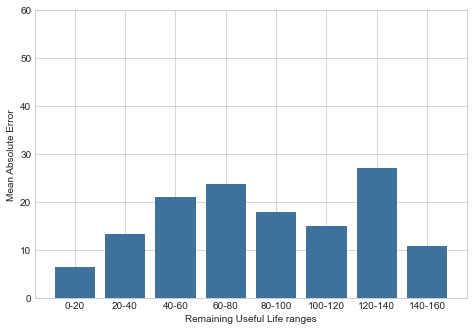

In [36]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '140-160']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,60)
plt.show()